# Ingeniería de Características (Featuring Engine)

**- Los nombres de las columnas son los siguientes:**

- Fecha
- Provincia
- Altitud
- tmed : temperatura media mendual/anual Cº
- prec : Precipitación (litros)
- tmin : Temperatura mínima
- horatmin : horatmin
- tmax : Temperatura máxima
- horatmax : Hora tmax
- dir : Dirección del viento
- velmedia : Velocidad media del viento
- racha : Velocidad racha de viento        #Nota: El viento no influye en nuestro target
- horaracha : Hora u horas de racha de viento
- presMax : Valor más alto de la presión atmosférica por días (A mayor valor menor probabilidad de lluvia)
- horaPresMax : Hora u horas punta de presión máxima
- presMin: Presión mímina por días
- horaPresMin: Hora u horas presión mínima
- hrMedia : Humedad relativa media
- hrMax : Humedad relativa máxima
- horaHrMax : Hora u Horas de la humedad relativa Máxima
- hrMin : Humedad relativa mínima
- horaHrMin : Hora u horas de la humedad relativa Mínima
- Sol : Número de horas al día con sol
- Municipio
- Latitud
- Longitud

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import plot_importance
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

import warnings

# Ignorar todos los warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)

# Selección de características principales

In [8]:
df = pd.read_csv('datos_clima_limpio_para_red_neuronal.csv')

In [9]:
df['horatmax'] = pd.to_datetime(df['horatmax'], errors='coerce')
df['horatmin'] = pd.to_datetime(df['horatmin'],  errors='coerce')
df['horaPresMax'] = pd.to_datetime(df['horaPresMax'], errors='coerce')
df['horaPresMin'] = pd.to_datetime(df['horaPresMin'],  errors='coerce')
df['horaHrMin'] = pd.to_datetime(df['horaHrMin'],  errors='coerce')
df['horaHrMax'] = pd.to_datetime(df['horaHrMax'],  errors='coerce')
df['horaracha'] = pd.to_datetime(df['horaracha'],  errors='coerce')

df['horaHrMax'] = df['horaHrMax'].dt.floor('S')
df['horaHrMax'] = df['horaracha'].dt.floor('S')

# Convertimos las fechas a timestamps positivos (segundos desde Epoch)
df['horatmin'] = pd.to_datetime(df['horatmin'], format='%Y-%m-%d %H:%M', errors='coerce')

# Indicamos la epoca así para corregir un desajuste horario. La primera sería 1.388531e+09 correspondiente al: 1/1/2014, 0:03:20.
epoca = '1970-01-01'

df['horatmin'] = (df['horatmin'] - pd.Timestamp(epoca)) / pd.Timedelta(seconds=1)
df['horatmax'] = (df['horatmax'] - pd.Timestamp(epoca)) / pd.Timedelta(seconds=1)
df['horaPresMax'] = (df['horaPresMax'] - pd.Timestamp(epoca)) / pd.Timedelta(seconds=1)
df['horaPresMin'] = (df['horaPresMin'] - pd.Timestamp(epoca)) / pd.Timedelta(seconds=1)
df['horaHrMin'] = (df['horaHrMin'] - pd.Timestamp(epoca)) / pd.Timedelta(seconds=1)
df['horaHrMax'] = (df['horaHrMax'] - pd.Timestamp(epoca)) / pd.Timedelta(seconds=1)
df['horaracha'] = (df['horaracha'] - pd.Timestamp(epoca)) / pd.Timedelta(seconds=1)

df['fecha'] = pd.to_datetime(df['fecha'], format='%Y-%m-%d', errors='coerce')
epoca = '1970-01-01'
df['fecha'] = (df['fecha'] - pd.Timestamp(epoca)) / pd.Timedelta(seconds=1)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['provincia'] = le.fit_transform(df['provincia'])
df['municipio'] = le.fit_transform(df['municipio'])

In [10]:
df.head(2)

,fecha,provincia,altitud,tmed,prec,tmin,tmax,horatmin,horatmax,hrMedia,hrMax,horaHrMax,hrMin,horaHrMin,dir,velmedia,racha,horaracha,presMax,horaPresMax,presMin,horaPresMin,sol,municipio,latitud,longitud,año,mes,dia,semana,estacion
0,1.388534e+09,18,808,7.2,1.2,5.0,9.3,1.388569e+09,1.388581e+09,92.0,97.0,1.388582e+09,86.0,1.388587e+09,99.0,4.4,10.0,1.388582e+09,926.4,1.388567e+09,921.3,1.388586e+09,0.0,117,40.010540,-3.006447,2014,1,1,0,1
1,1.388534e+09,25,17,14.1,0.0,10.8,17.4,1.388561e+09,1.388585e+09,74.0,90.0,1.388588e+09,53.0,1.388590e+09,99.0,2.2,9.7,1.388588e+09,1017.0,1.388565e+09,1014.1,1.388547e+09,7.8,97,39.415624,3.256301,2014,1,1,0,1


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428714 entries, 0 to 428713
Data columns (total 31 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   fecha        428714 non-null  float64
 1   provincia    428714 non-null  int64  
 2   altitud      428714 non-null  int64  
 3   tmed         428714 non-null  float64
 4   prec         428714 non-null  float64
 5   tmin         428714 non-null  float64
 6   tmax         428714 non-null  float64
 7   horatmin     428714 non-null  float64
 8   horatmax     428714 non-null  float64
 9   hrMedia      428714 non-null  float64
 10  hrMax        428714 non-null  float64
 11  horaHrMax    428714 non-null  float64
 12  hrMin        428714 non-null  float64
 13  horaHrMin    428714 non-null  float64
 14  dir          428714 non-null  float64
 15  velmedia     428714 non-null  float64
 16  racha        428714 non-null  float64
 17  horaracha    428714 non-null  float64
 18  presMax      428714 non-

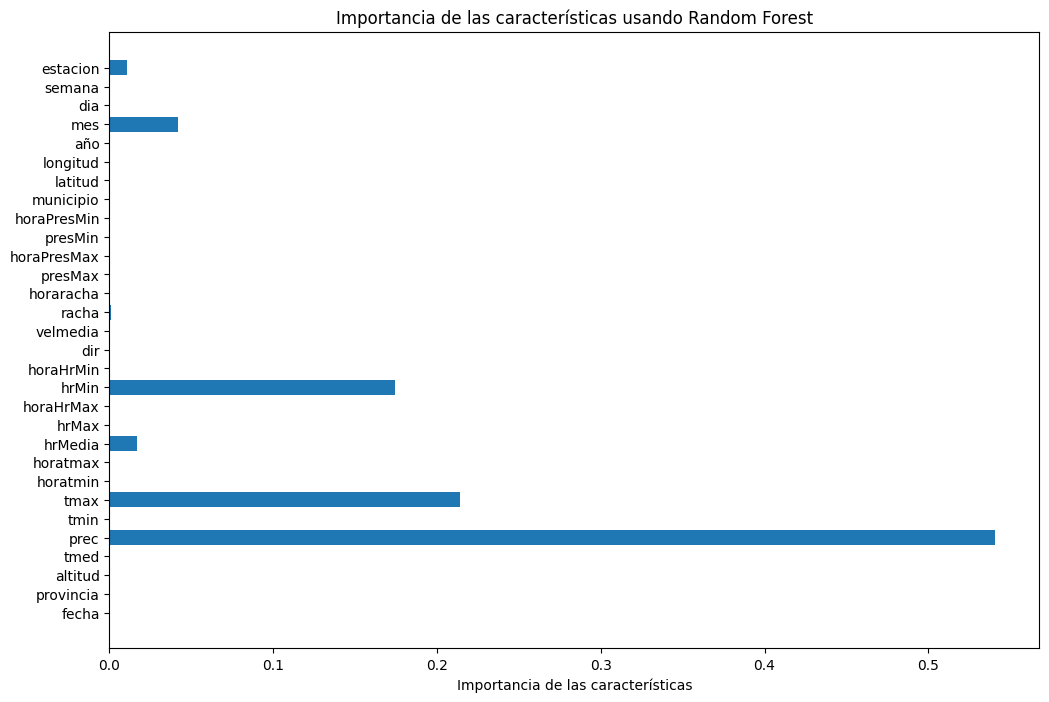

In [12]:
X = df.drop(columns=['sol'])
y = df['sol']

model = RandomForestRegressor(n_estimators=5, n_jobs=-1) #Normalmente el valor recomendado estará en 100

# Por defecto los dejamos estáticos, según la potencia del pc se pueden cambiar para que ofrezca mejores predicciones
param_grid = {
    'max_depth': [5],
    'min_samples_split': [10],
}

grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X, y)

best_model = grid_search.best_estimator_

importances = best_model.feature_importances_

plt.figure(figsize=(12, 8))
plt.barh(X.columns, importances)
plt.xlabel('Importancia de las características')
plt.title('Importancia de las características usando Random Forest')
plt.show()

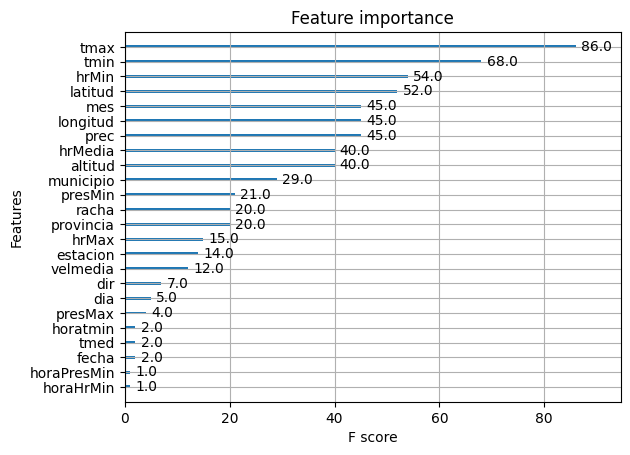

In [13]:
# Convertir datos a formato DMatrix para XGBoost
x_train = xgb.DMatrix(X, y)

params = {'objective': 'reg:squarederror'}  # Cambiar según el tipo de problema (regresión o clasificación)
model = xgb.train(params, x_train, num_boost_round=10)

plot_importance(model)
plt.show()

In [14]:
model = LinearRegression()

# Inicializamos RFE sin especificar n_features_to_select
selector = RFE(model, step=1)

selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = X.columns[selector.support_]

print("Características seleccionadas: ", selected_features)

scores = []
for n in range(1, X.shape[1]+1):
    selector = RFE(model, n_features_to_select=n)
    X_new = selector.fit_transform(X, y)
    score = cross_val_score(model, X_new, y, cv=5).mean()  # Validación cruzada
    scores.append(score)

best_n_features = scores.index(max(scores)) + 1
print(f"El número óptimo de características es: {best_n_features}")

Características seleccionadas:  Index(['tmed', 'prec', 'tmin', 'tmax', 'hrMedia', 'hrMax', 'hrMin', 'velmedia',
       'racha', 'horaracha', 'presMax', 'presMin', 'latitud', 'mes',
       'estacion'],
      dtype='object')
El número óptimo de características es: 22


# PARTE 2

In [15]:
# Obtenemos nuevas características descriptivas

# Obtenemos el rango en ese día de la temperatura máxima y mínima, el promedio de ambas y la desviación típica. Lo hacemos también para la humedad y la presión
df['rango_temperatura'] = df['tmax'] - df['tmin']
df['promedio_temperatura'] = (df['tmin'] + df['tmax']) / 2
df['desviacion_temperatura'] = df['tmed'] - df['promedio_temperatura']  # Desviación típica

df['temperatura_por_estacion'] = df['tmed'] * df['estacion']

df['temperatura_media_por_año'] = df.groupby(['municipio', 'año'])['tmed'].transform('mean')

df['rango_humedad'] = df['hrMax'] - df['hrMin']
df['promedio_humedad'] = (df['hrMax'] + df['hrMin']) / 2
df['desviacion_humedad'] = df['hrMedia'] - df['promedio_humedad']

df['rango_presion'] = df['presMax'] - df['presMin']
df['promedio_presion'] = (df['presMax'] + df['presMin']) / 2

# Si hay una temperatura media y una humedad media relativamente altas puede suponer que ha sido un día soleado, y por el contrario si son bajas puede suponer que ha hecho mal tiempo.
df['temp_humedad_medias'] = df['tmed'] * df['hrMedia']

# Dividimos el target en 24 horas para que encuentre una proporción de las horas respecto al día
df['proporcion_por_horas_sol'] = df['sol'] / 24

In [16]:
df['indice_humedad_temperatura'] = df['hrMedia'] * df['tmed']
df['relacion_prec_temperatura'] = df['tmed'] * df['prec']
df['relacion_viento_temperatura'] = df['velmedia'] * df['tmed']

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428714 entries, 0 to 428713
Data columns (total 46 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   fecha                        428714 non-null  float64
 1   provincia                    428714 non-null  int64  
 2   altitud                      428714 non-null  int64  
 3   tmed                         428714 non-null  float64
 4   prec                         428714 non-null  float64
 5   tmin                         428714 non-null  float64
 6   tmax                         428714 non-null  float64
 7   horatmin                     428714 non-null  float64
 8   horatmax                     428714 non-null  float64
 9   hrMedia                      428714 non-null  float64
 10  hrMax                        428714 non-null  float64
 11  horaHrMax                    428714 non-null  float64
 12  hrMin                        428714 non-null  float64
 13 

In [18]:
df.to_csv('CSV_para_entrenar_MODELO-RED-NEURONAL.csv', index=False)